In [4]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d

def plane(X, a, b, c):
    return(a*X[0] + b * X[1] + c)

def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)


class simpleStimData:
    
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
    def generate_time_trace_plot(self):
        fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw = {'height_ratios': [10, 1]}, subplot_kw = {'aspect': 1} )

        cmap = cm.get_cmap('viridis')
        col_vec = [cmap(i) for i in np.linspace(0, 1, len(self.ch3_stack))]
        for i in range(len(self.ch3_stack)):
            contours = measure.find_contours(self.ch3_stack[i] > 0, level = False)
            mat = self.transform_mats[i]

            for ctr in contours:
                y_pixel, x_pixel = ctr.T
                placeholder = np.ones_like(x_pixel)

                ctr_px = np.array([x_pixel, y_pixel, placeholder])

                y_um, x_um, placeholder = np.matmul(mat, ctr_px)
                ax[0].plot(x_um, y_um, color = col_vec[i], alpha = 0.9, zorder = 1)



        plt.plot(self.x_rotated, self.y_rotated, color = 'k', zorder = 0)
        ax[0].axis([-100, 100, -80, 120])

        ax[1].set_aspect(10)
        norm = mpl.colors.Normalize(vmin = 0, vmax = self.ch0_times[-1])

        cb1 = mpl.colorbar.ColorbarBase(ax[1], cmap=cmap,norm=norm,orientation='horizontal')
        cb1.set_label('Elapsed Time (s)')
        plt.tight_layout()

        plt.show()
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        

def delayed_exponential_on(t, b, tau, upper_lim, lower_lim):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b*(t - tau))
    de[t < tau] = lower_lim
    return(de)

def delayed_exponential_on_off(t, b_on, b_off, tau_on, tau_off, upper_lim, lower_lim, lower_lim2):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(t - tau_on))
    de[t < tau_on] = lower_lim
    
    val = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(tau_off - tau_on))
    de[t > tau_off] =  lower_lim2 + (val - lower_lim2) * np.exp(b_off*(t[t > tau_off] - tau_off))
    return(de)
        
        
class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = np.nan
        self.elapsed_time_s = np.nan
        self.channel = np.nan
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            


class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            
            if ('img' in i) & ('tif' in i):
                try:
                    i = i.decode()
                except:
                    pass

                if '.tif' in i:
                    img_obj = mm_microscope_image(self.acq_path + '/' + i)

                    try:
                        name_fragments = i.split('_')
                        img_obj.framenumber = int(name_fragments[3][4:])
                        img_obj.channel = int(name_fragments[1][7:])

                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                        img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                        img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                    except:
                        pass


                    self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]
        
        

## Figure S1A

In [2]:
datafolder = '/Users/jasontown/Desktop/201128_35-52-97-mCherryPAKPBD_twoSpot/'
f = '201128_35-52-97-mCherryPAK_undiff_10uMLatB_twoSpotSwap_3'

filepath = datafolder + f + '/'

mma = mm_acquisition(filepath)
pixum = mma.microscope_image_list[0].pixelsizeum

if (pixum == 0) | (pixum is None):
    pixum = 0.217

ch0_baseline = []
ch1_baseline = []

ch0D = []
ch1D = []

D = 100
xc = 730
yc = 510

ch0 = mma.ch0_stack_bgcorrected[0][yc-D:yc+D,xc-D:xc+D]
smth_ch0 = filters.gaussian(ch0, 2, preserve_range=True)
bin_ch0 = smth_ch0 > 100
bin_ch0 = morphology.remove_small_objects(bin_ch0, 100)
lbl_ch0 = measure.label(bin_ch0)
reg_ch0 = measure.regionprops(lbl_ch0)
dist_to_middle = np.array([np.hypot(r.centroid[0] - D, r.centroid[1] - D) for r in reg_ch0])
lbl_of_interest = reg_ch0[np.argmin(dist_to_middle)].label
isolated_cell = lbl_ch0 == lbl_of_interest
yc, xc = measure.regionprops(measure.label(isolated_cell))[0].centroid
yc, xc = 510+int(yc)-D, 730+int(xc)-D

cmax0 = 1.1*np.percentile(mma.ch0_stack_bgcorrected[15][yc-D:yc+D,xc-D:xc+D], 99.999)
cmax1 = 1.1*np.percentile(mma.ch1_stack_bgcorrected[15][yc-D:yc+D,xc-D:xc+D], 99.999)

for T in range(len(mma.ch0_stack)):
    
    
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]

    if T == 0:
        smth_ch0 = filters.gaussian(ch0, 2, preserve_range=True)
        bin_ch0 = smth_ch0 > 100
        bin_ch0 = morphology.remove_small_objects(bin_ch0, 100)
        lbl_ch0 = measure.label(bin_ch0)
        reg_ch0 = measure.regionprops(lbl_ch0)
        dist_to_middle = np.array([np.hypot(r.centroid[0] - D, r.centroid[1] - D) for r in reg_ch0])
        lbl_of_interest = reg_ch0[np.argmin(dist_to_middle)].label
        isolated_cell = lbl_ch0 == lbl_of_interest

    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600

    yy, xx = np.where(isolated_cell)




/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_25910/1817371095.py:203: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_25910/1817371095.py:224: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))


/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_25910/1865117031.py:15: UserWarning: No contour levels were found within the data range.
  plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_25910/1865117031.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')


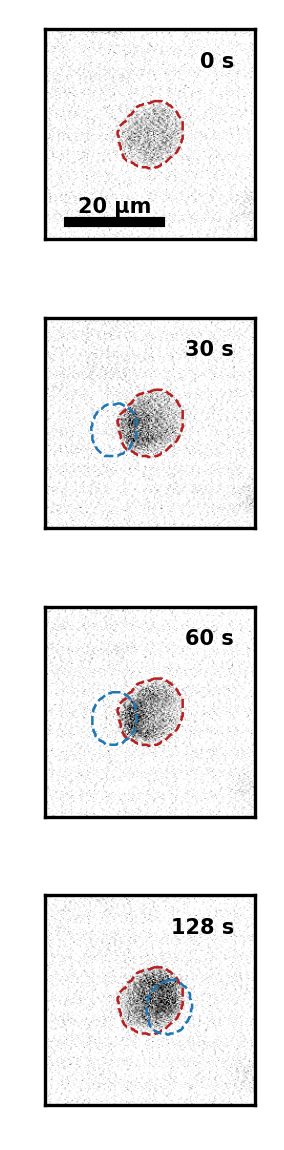

In [3]:
t1 = mma.elapsedtimes[mma.channels == 1]
t1 -= t1[25]

plt.figure(figsize = (1, 4), dpi = 300)

for n, T in enumerate([25, 38, 51, 80]):
    ax = plt.subplot(4, 1, n + 1)
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]
    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600
    
    plt.imshow(ch1, cmap = 'Greys', vmin = 0, vmax = 200)
    plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
    plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')
    rect = mp.Rectangle((0.2*D, 1.8*D), 20/pixum, 6, color = 'k')
    if n == 0:
        ax.add_patch(rect)
        ax.text(0.2 * D + 10/pixum, 1.78*D, '20 μm', ha = 'center', va = 'bottom', fontweight = 'bold', fontsize = 5)

    timestamp = int(np.round(t1[T], 0))
    ax.text(1.8*D, 0.2*D, str(timestamp) + ' s', ha = 'right', va = 'top', fontsize = 5, fontweight = 'bold')

    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()


/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_25910/1099016441.py:28: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, t1, np.array(smth_ch2_kymo) > 600, levels = [False], colors = 'C0', linewidths = 2)


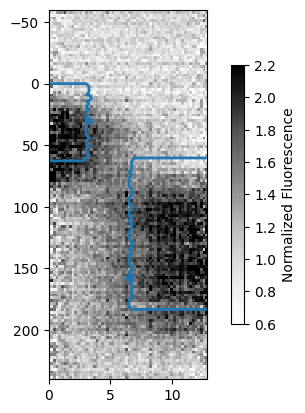

In [13]:
ch0_kymo = []
ch1_kymo = []
ch2_kymo = []

ch0_baseline = np.average(mma.ch0_stack_bgcorrected[:25,yc-D:yc+D,xc-D:xc+D], axis = 0)[yy, xx]
ch1_baseline = np.average(mma.ch1_stack_bgcorrected[:25,yc-D:yc+D,xc-D:xc+D], axis = 0)[yy, xx]

for T in range(len(mma.ch0_stack_bgcorrected)):
    ch0sig = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D][yy, xx]/ch0_baseline
    horizontal_mean = stats.binned_statistic(xx, ch0sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch0_kymo.append(horizontal_mean[0])
    
    ch1sig = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D][yy, xx]/ch1_baseline
    horizontal_mean = stats.binned_statistic(xx, ch1sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch1_kymo.append(horizontal_mean[0])
    
    ch2sig = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D][yy, xx]
    horizontal_mean = stats.binned_statistic(xx, ch2sig, bins = np.arange(np.min(xx), np.max(xx) + 1))
    ch2_kymo.append(horizontal_mean[0])
    
x1 = pixum*np.arange(len(ch1_kymo[0]))
smth_ch2_kymo = ch2_kymo

plt.subplot(111, aspect = 0.1)
pcm = plt.pcolormesh(x1,t1, np.array(ch1_kymo), vmin = 0.6, vmax = 2.2, cmap = 'Greys')
plt.colorbar(label = 'Normalized Fluorescence', shrink = 0.7)
plt.axis([0, np.max(x1), 240, -60])
plt.contour(x1, t1, np.array(smth_ch2_kymo) > 600, levels = [False], colors = 'C0', linewidths = 2)

plt.show()

## Figure S1B

In [5]:
parent = '/home/jason/Data/simpleStimData/'

global_ch0_frontback = []
global_ch1_frontback = []


ch0_avg_dynamics = []
ch1_avg_dynamics = []

for fname in os.listdir(parent):
    if '_global_' in fname:
        a = simpleStimData(parent + fname)
        a.calculate_frontbackSignals()
        global_ch0_frontback.append(a.ch0_frontback)
        global_ch1_frontback.append(a.ch1_frontback)
        
        a.calculate_global_dynamics()
        ch0_avg_dynamics.append(a.ch0_dynamics)
        ch1_avg_dynamics.append(a.ch1_dynamics)
        
global_ch0_frontback = np.array(global_ch0_frontback)
global_ch1_frontback = np.array(global_ch1_frontback)

/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/jason/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jason/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
parent = '/home/jason/Data/simpleStimData/'

frontstim_ch0_frontback = []
frontstim_ch1_frontback = []

ch0_avg_dynamics = []
ch1_avg_dynamics = []

for fname in os.listdir(parent):
    if '_front_' in fname:
        a = simpleStimData(parent + fname)
        a.calculate_frontbackSignals()
        frontstim_ch0_frontback.append(a.ch0_frontback)
        frontstim_ch1_frontback.append(a.ch1_frontback)
        
        a.calculate_global_dynamics()
        ch0_avg_dynamics.append(a.ch0_dynamics)
        ch1_avg_dynamics.append(a.ch1_dynamics)
        
frontstim_ch0_frontback = np.array(frontstim_ch0_frontback)
frontstim_ch1_frontback = np.array(frontstim_ch1_frontback)

In [7]:
parent = '/home/jason/Data/simpleStimData/'

nonestim_ch0_frontback = []
nonestim_ch1_frontback = []

ch0_avg_dynamics = []
ch1_avg_dynamics = []

for fname in os.listdir(parent):
    if '_none_' in fname:
        a = simpleStimData(parent + fname)
        a.calculate_frontbackSignals()
        nonestim_ch0_frontback.append(a.ch0_frontback)
        nonestim_ch1_frontback.append(a.ch1_frontback)
        
        a.calculate_global_dynamics()
        ch0_avg_dynamics.append(a.ch0_dynamics)
        ch1_avg_dynamics.append(a.ch1_dynamics)
        
nonestim_ch0_frontback = np.array(nonestim_ch0_frontback)
nonestim_ch1_frontback = np.array(nonestim_ch1_frontback)

In [8]:
global_ch0_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in global_ch0_frontback])
global_ch1_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in global_ch1_frontback])

ch0_globalstim_frontback_avg = np.nanmean(global_ch0_frontback_basenorm, axis = 0)
ch1_globalstim_frontback_avg = np.nanmean(global_ch1_frontback_basenorm, axis = 0)


frontstim_ch0_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in frontstim_ch0_frontback])
frontstim_ch1_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in frontstim_ch1_frontback])

ch0_frontstim_frontback_avg = np.nanmean(frontstim_ch0_frontback_basenorm, axis = 0)
ch1_frontstim_frontback_avg = np.nanmean(frontstim_ch1_frontback_basenorm, axis = 0)


nonestim_ch0_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in nonestim_ch0_frontback])
nonestim_ch1_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in nonestim_ch1_frontback])

ch0_nonestim_frontback_avg = np.nanmean(nonestim_ch0_frontback_basenorm, axis = 0)
ch1_nonestim_frontback_avg = np.nanmean(nonestim_ch1_frontback_basenorm, axis = 0)

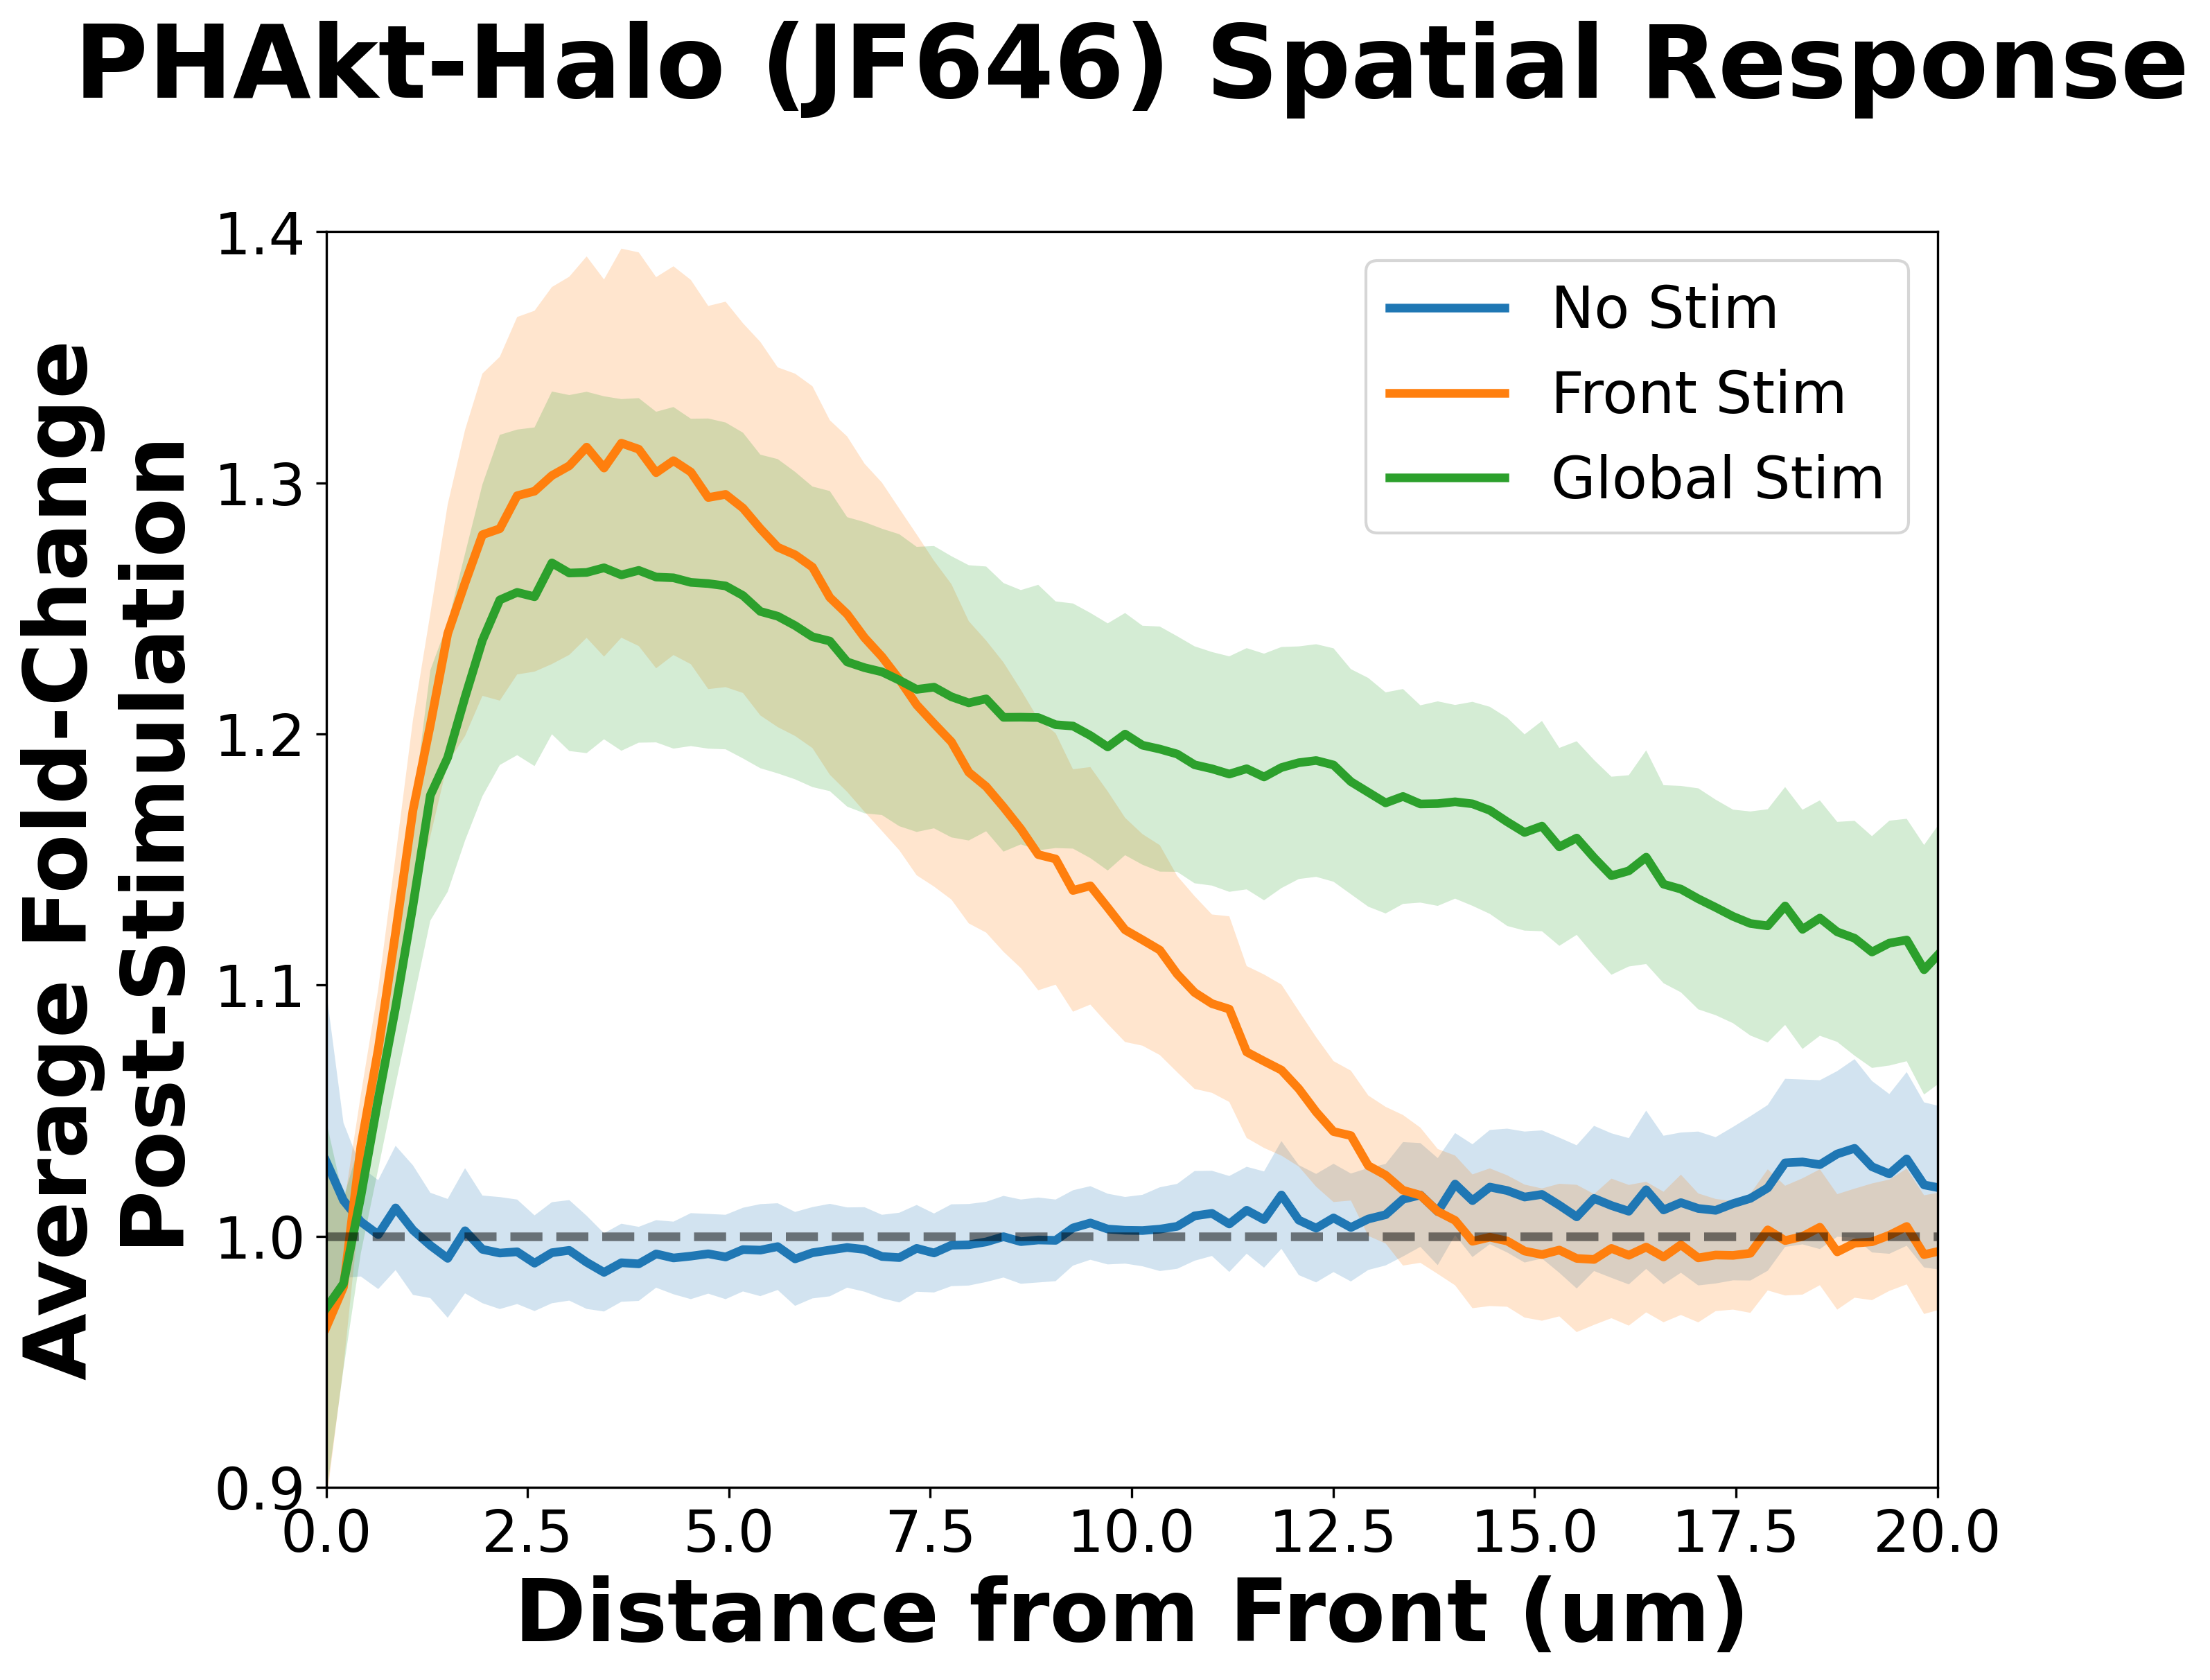

In [55]:
plt.figure(figsize = (10, 8), dpi = 300)

x = np.arange(100) * 0.2156

count = 0
legend_lbls = ['No Stim', 'Front Stim', 'Global Stim']
for D in [ch1_nonestim_frontback_avg, ch1_frontstim_frontback_avg, ch1_globalstim_frontback_avg]:
    basal_spatial = np.average(D[:10], axis = 0)
    FC_ch1 = [i/basal_spatial for i in D]
    
    m = np.nanmean(FC_ch1[10:], axis = 0)
    s = np.nanstd(FC_ch1[10:], axis = 0)
    plt.plot(x, m, lw = 3, label = legend_lbls[count])
    plt.fill_between(x, m - s, m + s, alpha = 0.2)
    count += 1
    
plt.ylim(0.9, 1.4)
plt.xlim(0, 20)
plt.axhline(1, ls = '--', lw = 3, color = 'k', alpha = 0.5)
plt.ylabel('Average Fold-Change\n Post-Stimulation', fontweight = 'bold', fontsize = 30)
plt.xlabel('Distance from Front (um)', fontweight = 'bold', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(prop={'size': 20})
plt.title('PHAkt-Halo (JF646) Spatial Response\n', fontweight = 'bold', fontsize = 35)
plt.show()
